In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision.transforms import Compose, ToTensor
from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
import random
import math
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

# Loading data

In [2]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.n_samples = 0
        self.dataset = []
        self.load_audio_files(self.data_dir)
        
    def load_audio_files(self, path: str):
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:

                file_path = os.path.join(dirname, filename)
                label = dirname.split('/')[-1]
                label = torch.tensor([ord(label) - ord('a')])
                

                # Load audio
                waveform, sample_rate = torchaudio.load(file_path)
                if self.transform is not None:
                    waveform_transformed = self.transform(waveform)
                
                if waveform_transformed.shape[2] != 64:
                    print("Wrong shape:", waveform_transformed.shape)
                    continue
                
                self.n_samples += 1
                self.dataset.append((waveform, label))

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        waveform, label = self.dataset[idx]
        return waveform, label

In [3]:
sample_rate = 44100
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=64, hop_length=300, n_fft=1024+512, win_length=1024, f_min = 100, f_max=2500)
mel_spectrogram_to_numpy = lambda spectrogram: spectrogram.log2()[0,:,:].numpy()
transforms = Compose([to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor()])
dataset = AudioDataset('/kaggle/input/keyboard-sounds', transforms)

Wrong shape: torch.Size([1, 64, 31])
Wrong shape: torch.Size([1, 64, 33])
Wrong shape: torch.Size([1, 64, 25])


In [4]:
train_size = 30 * 26 - 1 # 3 files were malformed
val_size = 10 * 26 - 1
test_size = 10 * 26 - 1
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data augmentation setup

In [5]:
class TrainingDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrainingDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        waveform, label = self.base[idx]
        return self.transformations(waveform), label

In [6]:
class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()        
        shift = int(samples.shape[1] * 0.3)
        random_shift = random.randint(0, shift)
        data_roll = np.zeros_like(samples)
        data_roll[0] = np.roll(samples[0], random_shift)
        data_roll[1] = np.roll(samples[1], random_shift)
        return torch.tensor(data_roll)

In [7]:
aug_transforms = Compose([
    TimeShifting(),
    to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor(),
    FrequencyMasking(7),
    TimeMasking(7),
    FrequencyMasking(7),
    TimeMasking(7)
])
train_set = TrainingDataset(train_set, aug_transforms)
val_set = TrainingDataset(val_set, transforms)
test_set = TrainingDataset(test_set, transforms)

## Training set image (augmented)

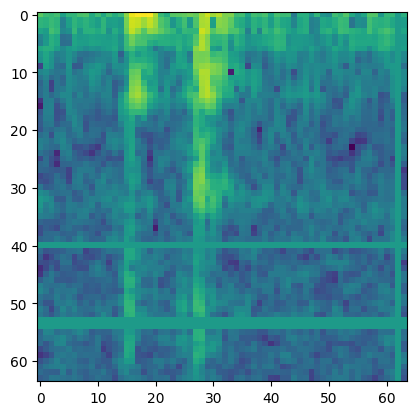

In [8]:
plt.imshow(train_set[0][0][0], cmap='viridis')

## Validation set image (not augmented)

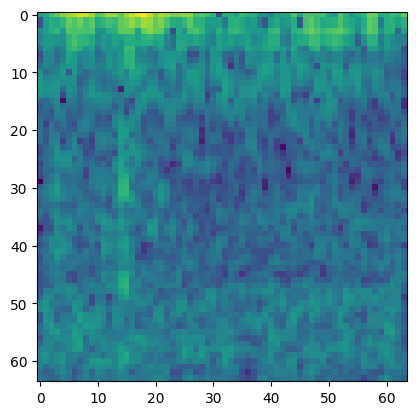

In [9]:
plt.imshow(transforms(dataset[2][0])[0], cmap='viridis')

# CoAtNet

In [10]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [11]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [12]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [13]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) #Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [14]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [15]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [16]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [17]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [18]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [19]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=26):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [20]:
# CoAtNet-1
nums_blocks = [2, 2, 6, 14, 2]           # L
channels = [64, 96, 192, 384, 768]      # D
model = MyCoAtNet(nums_blocks, channels)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
!pip install torchsummary

In [22]:
# Taken from MyCoAtNet
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Taken from MyCoAtNet
model.apply(init_linear)
model.to(device);
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))
from torchinfo import summary
from torchsummary import summary
summary(model, input_size=(1, 64, 64))

Number of parameters: 41,808,178
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

# Training

In [24]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    num_workers=2,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    num_workers=2,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    num_workers=2,
    shuffle=True
)

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [26]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [27]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.AdamW(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [28]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [29]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

Epoch [1/1100], Loss: 17.29059410095215, Accuracy: 0.06546854942233633 Correct: 51 Total: 779 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.0694980694980695 Validation loss: 21.81877326965332 Correct: 18 Total: 259
Epoch [2/1100], Loss: 21.033143997192383, Accuracy: 0.10269576379974327 Correct: 80 Total: 779 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.11583011583011583 Validation loss: 28.552520751953125 Correct: 30 Total: 259
Epoch [3/1100], Loss: 13.239933013916016, Accuracy: 0.12836970474967907 Correct: 100 Total: 779 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.11969111969111969 Validation loss: 16.071165084838867 Correct: 31 Total: 259
Epoch [4/1100], Loss: 7.999475002288818, Accuracy: 0.15532734274711169 Correct: 121 Total: 779 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.15444015444015444 Validation loss: 15.985645294189453 Correct: 40 Total: 259
Epoch [5/1100], Loss: 14.6318597793

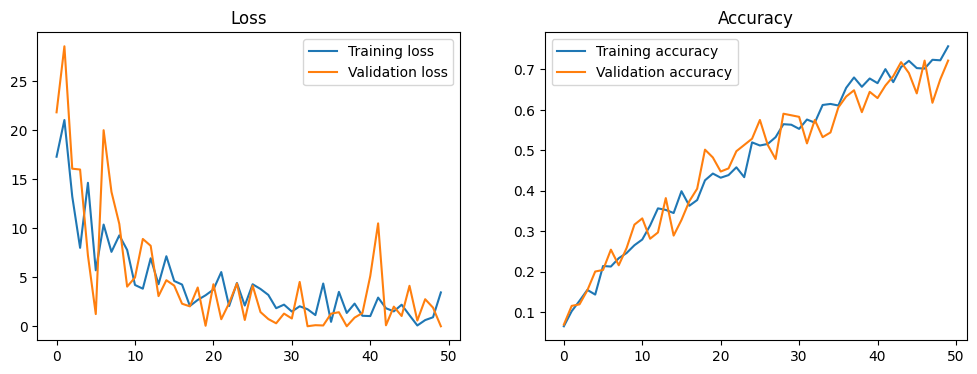

Epoch [51/1100], Loss: 1.1492191553115845, Accuracy: 0.748395378690629 Correct: 583 Total: 779 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.694980694980695 Validation loss: 6.766733169555664 Correct: 180 Total: 259
Epoch [52/1100], Loss: 1.7515506744384766, Accuracy: 0.7522464698331194 Correct: 586 Total: 779 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.752895752895753 Validation loss: 0.0065363552421331406 Correct: 195 Total: 259
Epoch [53/1100], Loss: 0.3639521300792694, Accuracy: 0.7329910141206675 Correct: 571 Total: 779 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.7413127413127413 Validation loss: 2.970179319381714 Correct: 192 Total: 259
Epoch [54/1100], Loss: 0.27075186371803284, Accuracy: 0.7342747111681643 Correct: 572 Total: 779 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.7142857142857143 Validation loss: 0.0287577286362648 Correct: 185 Total: 259
Epoch [55/1

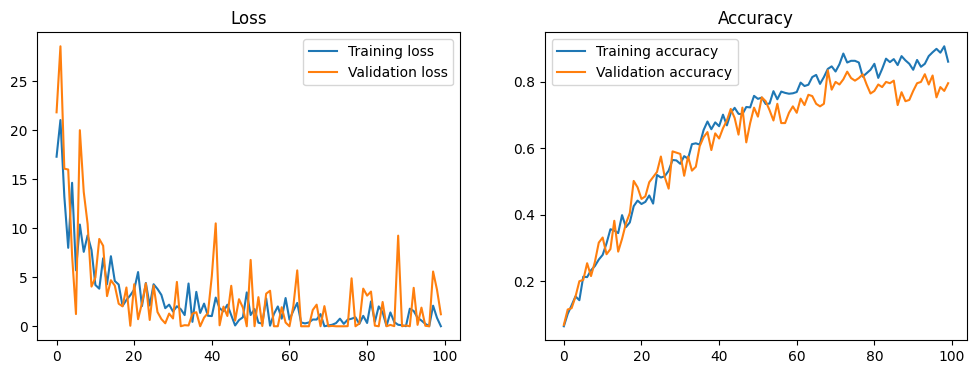

Epoch [101/1100], Loss: 0.05422874912619591, Accuracy: 0.889602053915276 Correct: 693 Total: 779 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.7413127413127413 Validation loss: 0.045512836426496506 Correct: 192 Total: 259
Epoch [102/1100], Loss: 0.4630345106124878, Accuracy: 0.8741976893453145 Correct: 681 Total: 779 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.8185328185328186 Validation loss: 0.012591522186994553 Correct: 212 Total: 259
Epoch [103/1100], Loss: 0.5606931447982788, Accuracy: 0.8870346598202824 Correct: 691 Total: 779 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.8416988416988417 Validation loss: 3.234389077988453e-05 Correct: 218 Total: 259
Epoch [104/1100], Loss: 0.6319305896759033, Accuracy: 0.8921694480102695 Correct: 695 Total: 779 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.8185328185328186 Validation loss: 1.6529944332432933e-05 Correct: 212 Total

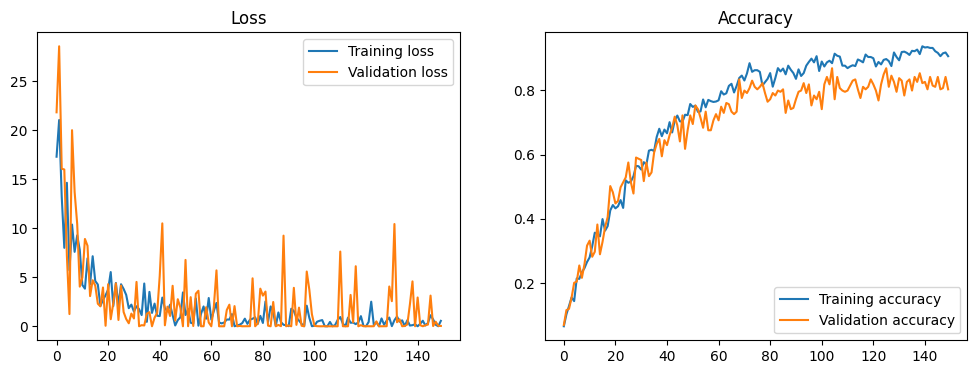

Epoch [151/1100], Loss: 1.2734216451644897, Accuracy: 0.926829268292683 Correct: 722 Total: 779 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.7915057915057915 Validation loss: 4.449278354644775 Correct: 205 Total: 259
Epoch [152/1100], Loss: 0.7379136681556702, Accuracy: 0.9319640564826701 Correct: 726 Total: 779 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.8455598455598455 Validation loss: 2.4514989852905273 Correct: 219 Total: 259
Epoch [153/1100], Loss: 0.001189724076539278, Accuracy: 0.9024390243902439 Correct: 703 Total: 779 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.8416988416988417 Validation loss: 2.2480008602142334 Correct: 218 Total: 259
Epoch [154/1100], Loss: 4.313578028813936e-05, Accuracy: 0.9422336328626444 Correct: 734 Total: 779 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.8301158301158301 Validation loss: 2.4911718368530273 Correct: 215 Total: 259
Epo

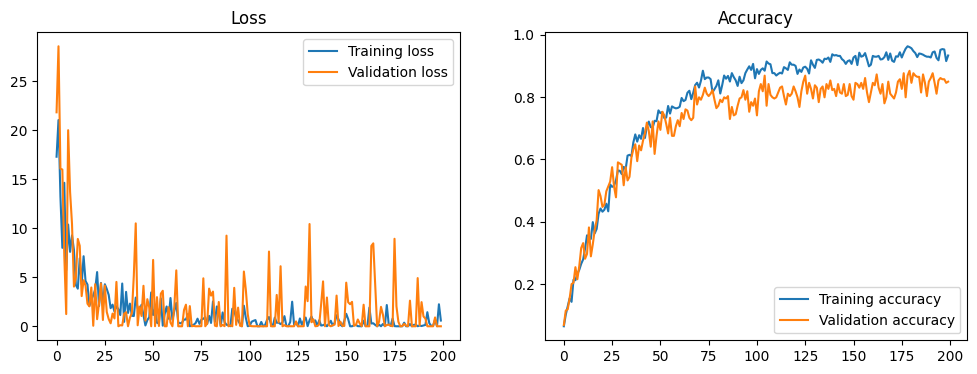

Epoch [201/1100], Loss: 0.001656987122260034, Accuracy: 0.944801026957638 Correct: 736 Total: 779 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.8648648648648649 Validation loss: 0.00017634335381444544 Correct: 224 Total: 259
Epoch [202/1100], Loss: 0.004740443546324968, Accuracy: 0.9370988446726572 Correct: 730 Total: 779 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.8571428571428571 Validation loss: 7.94728478581419e-08 Correct: 222 Total: 259
Epoch [203/1100], Loss: 0.4730461835861206, Accuracy: 0.9435173299101413 Correct: 735 Total: 779 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.8687258687258688 Validation loss: 0.10104086250066757 Correct: 225 Total: 259
Epoch [204/1100], Loss: 1.6938167810440063, Accuracy: 0.9409499358151476 Correct: 733 Total: 779 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.8455598455598455 Validation loss: 7.21286153793335 Correct: 219 Total: 

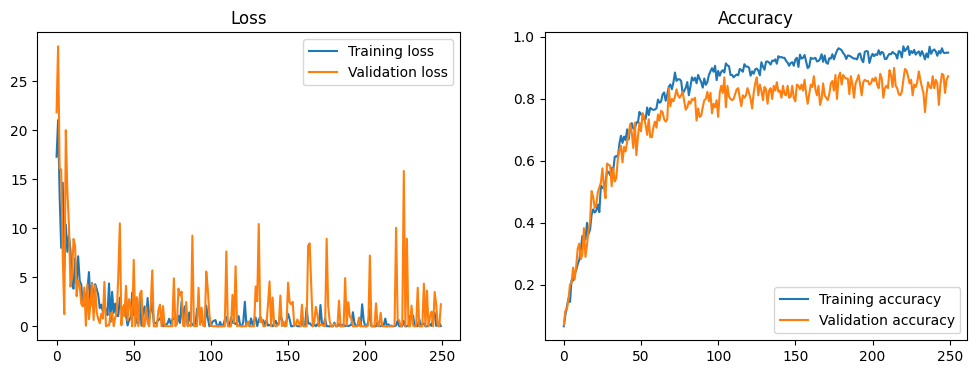

Epoch [251/1100], Loss: 0.8145267367362976, Accuracy: 0.9435173299101413 Correct: 735 Total: 779 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.8764478764478765 Validation loss: 0.003048546612262726 Correct: 227 Total: 259
Epoch [252/1100], Loss: 0.0009971000254154205, Accuracy: 0.9563543003851092 Correct: 745 Total: 779 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.8957528957528957 Validation loss: 0.0010806737700477242 Correct: 232 Total: 259
Epoch [253/1100], Loss: 0.46449458599090576, Accuracy: 0.9691912708600771 Correct: 755 Total: 779 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.8648648648648649 Validation loss: 0.44437360763549805 Correct: 224 Total: 259
Epoch [254/1100], Loss: 0.9610599875450134, Accuracy: 0.9486521181001284 Correct: 739 Total: 779 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.861003861003861 Validation loss: 3.3655054721748456e-05 Correct: 223 To

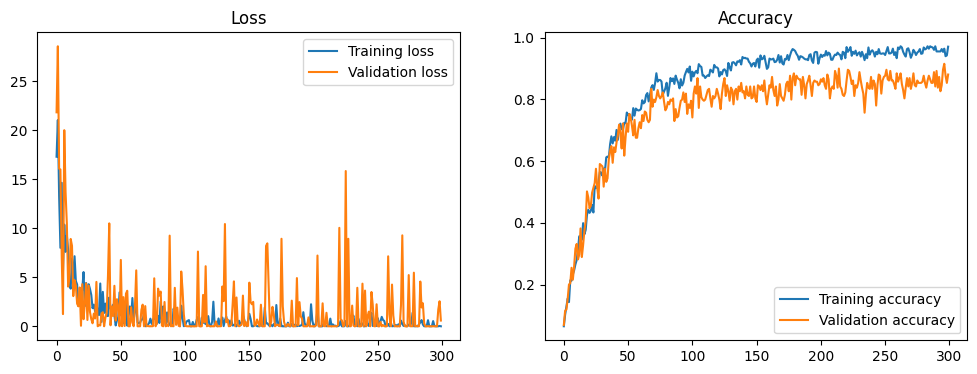

Epoch [301/1100], Loss: 0.2559252977371216, Accuracy: 0.962772785622593 Correct: 750 Total: 779 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.8378378378378378 Validation loss: 16.07917022705078 Correct: 217 Total: 259
Epoch [302/1100], Loss: 0.029514195397496223, Accuracy: 0.9550706033376123 Correct: 744 Total: 779 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.8648648648648649 Validation loss: 1.5165427923202515 Correct: 224 Total: 259
Epoch [303/1100], Loss: 0.43776682019233704, Accuracy: 0.9563543003851092 Correct: 745 Total: 779 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.861003861003861 Validation loss: 0.10161072760820389 Correct: 223 Total: 259
Epoch [304/1100], Loss: 0.0035848564002662897, Accuracy: 0.9614890885750963 Correct: 749 Total: 779 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.8764478764478765 Validation loss: 9.337930350739043e-06 Correct: 227 Total: 2

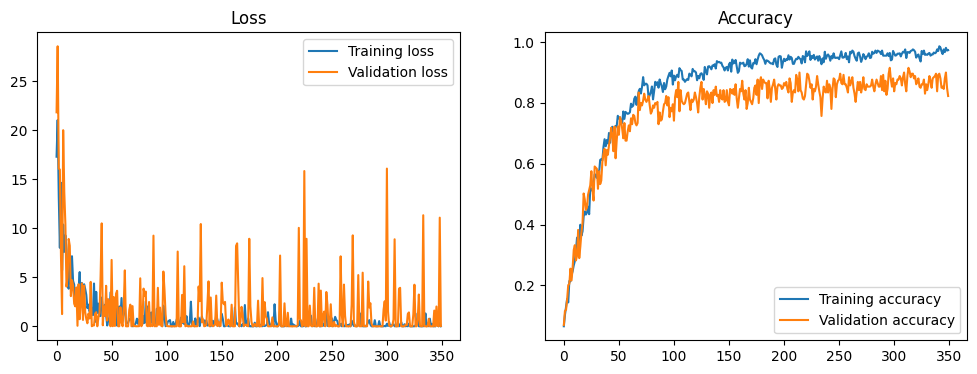

Epoch [351/1100], Loss: 0.2245059609413147, Accuracy: 0.9666238767650834 Correct: 753 Total: 779 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.8571428571428571 Validation loss: 4.113119125366211 Correct: 222 Total: 259
Epoch [352/1100], Loss: 0.0012899809516966343, Accuracy: 0.9486521181001284 Correct: 739 Total: 779 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.888030888030888 Validation loss: 4.436461925506592 Correct: 230 Total: 259
Epoch [353/1100], Loss: 0.021991100162267685, Accuracy: 0.9602053915275995 Correct: 748 Total: 779 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.8996138996138996 Validation loss: 0.0 Correct: 233 Total: 259
Epoch [354/1100], Loss: 0.00017651673988439143, Accuracy: 0.9743260590500642 Correct: 759 Total: 779 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.8648648648648649 Validation loss: 1.5857229232788086 Correct: 224 Total: 259
Epoch [355/1100]

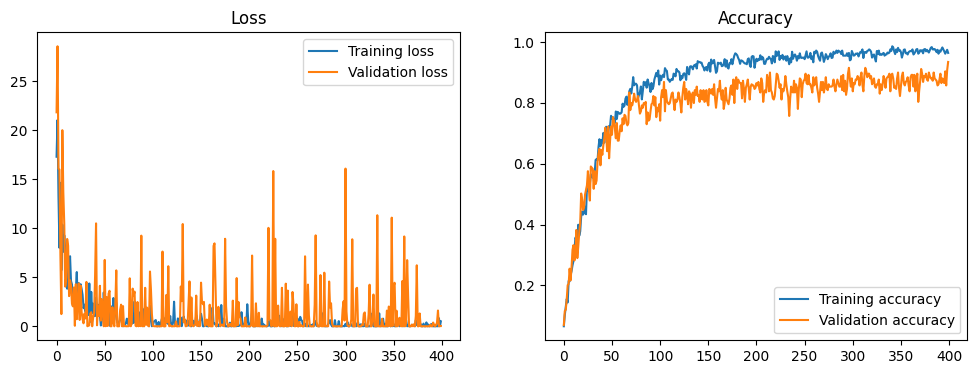

Epoch [401/1100], Loss: 0.43081119656562805, Accuracy: 0.9666238767650834 Correct: 753 Total: 779 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.8648648648648649 Validation loss: 1.0132635907211807e-05 Correct: 224 Total: 259
Epoch [402/1100], Loss: 7.059900963213295e-05, Accuracy: 0.9576379974326059 Correct: 746 Total: 779 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.861003861003861 Validation loss: 0.0 Correct: 223 Total: 259
Epoch [403/1100], Loss: 7.19853924238123e-05, Accuracy: 0.9691912708600771 Correct: 755 Total: 779 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.8803088803088803 Validation loss: 4.17043399810791 Correct: 228 Total: 259
Epoch [404/1100], Loss: 0.00021712011948693544, Accuracy: 0.9691912708600771 Correct: 755 Total: 779 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.8764478764478765 Validation loss: 0.41950464248657227 Correct: 227 Total: 259
Epoch [

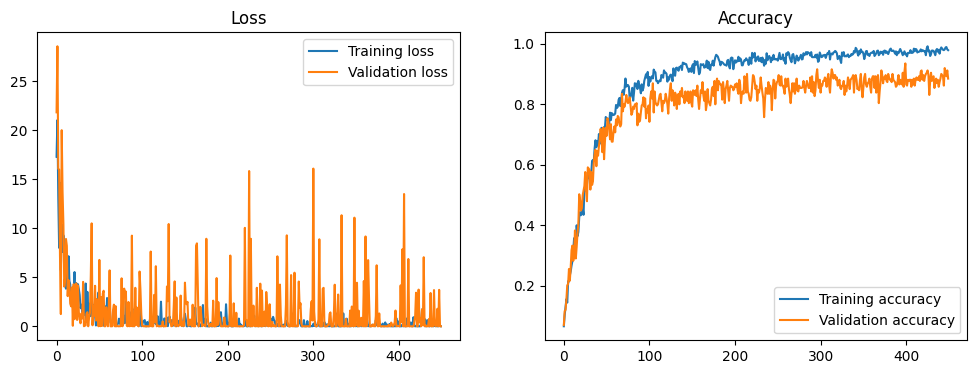

Epoch [451/1100], Loss: 0.00013011366536375135, Accuracy: 0.9666238767650834 Correct: 753 Total: 779 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.8687258687258688 Validation loss: 2.5177688598632812 Correct: 225 Total: 259
Epoch [452/1100], Loss: 0.0003237577329855412, Accuracy: 0.9768934531450578 Correct: 761 Total: 779 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.8841698841698842 Validation loss: 0.00016534361930098385 Correct: 229 Total: 259
Epoch [453/1100], Loss: 0.0003314181522000581, Accuracy: 0.9781771501925546 Correct: 762 Total: 779 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.8648648648648649 Validation loss: 1.7006757843773812e-05 Correct: 224 Total: 259
Epoch [454/1100], Loss: 8.838239591568708e-05, Accuracy: 0.9833119383825417 Correct: 766 Total: 779 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.8764478764478765 Validation loss: 0.00453488714993 Correct: 22

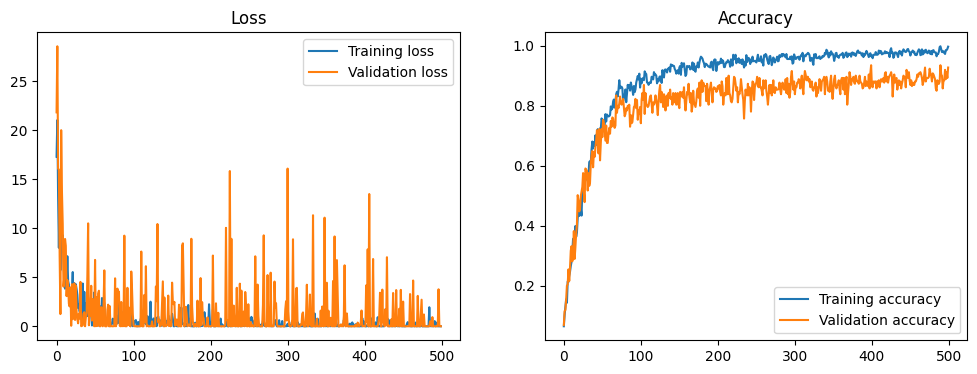

Epoch [501/1100], Loss: 0.022220075130462646, Accuracy: 0.9922978177150192 Correct: 773 Total: 779 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.8957528957528957 Validation loss: 6.755186063855945e-07 Correct: 232 Total: 259
Epoch [502/1100], Loss: 0.0003371362399775535, Accuracy: 0.9743260590500642 Correct: 759 Total: 779 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.8803088803088803 Validation loss: 0.0020954569336026907 Correct: 228 Total: 259
Epoch [503/1100], Loss: 8.745403647480998e-06, Accuracy: 0.982028241335045 Correct: 765 Total: 779 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.9266409266409267 Validation loss: 3.2843034267425537 Correct: 240 Total: 259
Epoch [504/1100], Loss: 5.8939054724760354e-05, Accuracy: 0.9807445442875481 Correct: 764 Total: 779 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.915057915057915 Validation loss: 0.0424589179456234 Correct: 237

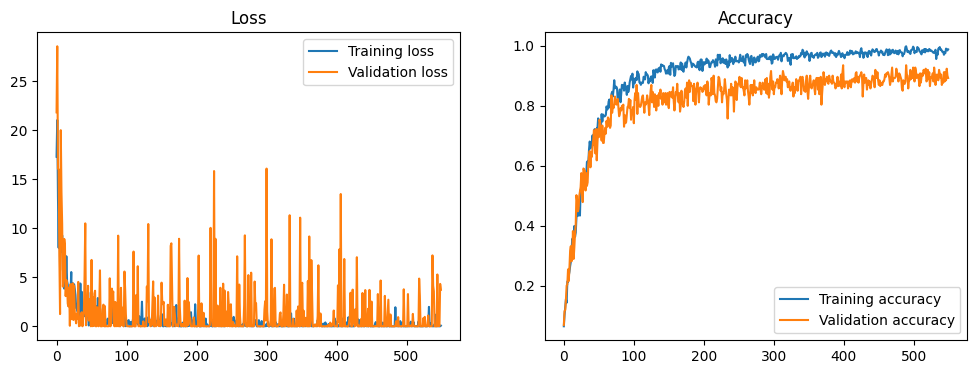

Epoch [551/1100], Loss: 4.679006815422326e-05, Accuracy: 0.9858793324775353 Correct: 768 Total: 779 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.918918918918919 Validation loss: 5.210093975067139 Correct: 238 Total: 259
Epoch [552/1100], Loss: 0.007227305788546801, Accuracy: 0.9897304236200257 Correct: 771 Total: 779 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.8957528957528957 Validation loss: 3.4570514344522962e-06 Correct: 232 Total: 259
Epoch [553/1100], Loss: 9.645082172937691e-07, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.918918918918919 Validation loss: 1.351037212771189e-06 Correct: 238 Total: 259
Epoch [554/1100], Loss: 1.0165063031308819e-05, Accuracy: 0.9858793324775353 Correct: 768 Total: 779 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.918918918918919 Validation loss: 0.06115766987204552 Correct: 238

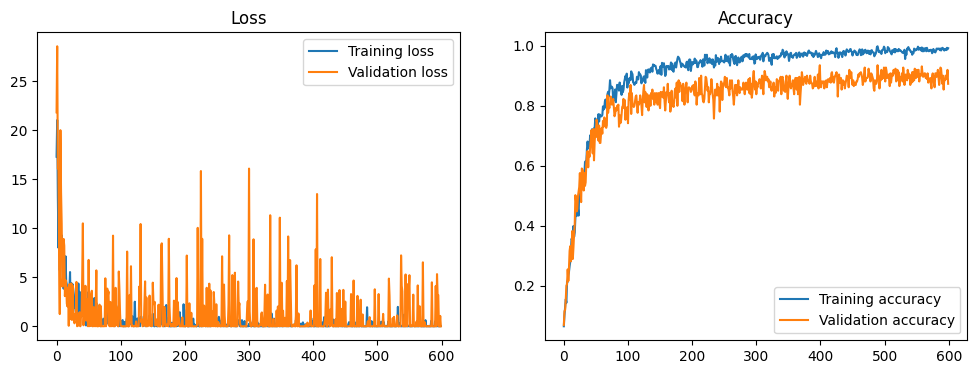

Epoch [601/1100], Loss: 0.002787618897855282, Accuracy: 0.9922978177150192 Correct: 773 Total: 779 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.8996138996138996 Validation loss: 0.0028903773054480553 Correct: 233 Total: 259
Epoch [602/1100], Loss: 1.4391188415174838e-05, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.9034749034749034 Validation loss: 0.0 Correct: 234 Total: 259
Epoch [603/1100], Loss: 0.00015435829118359834, Accuracy: 0.9948652118100129 Correct: 775 Total: 779 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.8957528957528957 Validation loss: 0.0 Correct: 232 Total: 259
Epoch [604/1100], Loss: 1.3188438970246352e-05, Accuracy: 0.9922978177150192 Correct: 773 Total: 779 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.9034749034749034 Validation loss: 0.0001320578739978373 Correct: 234 Total: 259
Epoch [605/1

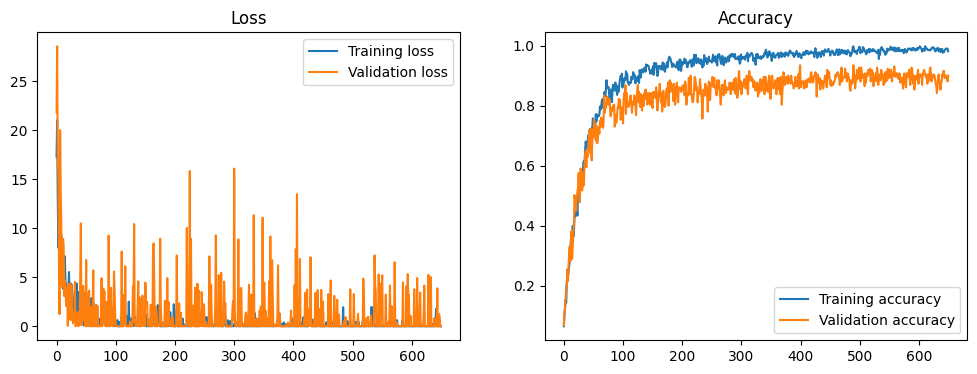

Epoch [651/1100], Loss: 0.0023488292936235666, Accuracy: 0.9858793324775353 Correct: 768 Total: 779 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.9073359073359073 Validation loss: 0.0 Correct: 235 Total: 259
Epoch [652/1100], Loss: 1.1812483080575475e-06, Accuracy: 0.9910141206675225 Correct: 772 Total: 779 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.8918918918918919 Validation loss: 0.058597248047590256 Correct: 231 Total: 259
Epoch [653/1100], Loss: 0.00015178369358181953, Accuracy: 0.9948652118100129 Correct: 775 Total: 779 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.888030888030888 Validation loss: 1.4304853721114341e-05 Correct: 230 Total: 259
Epoch [654/1100], Loss: 0.006281925830990076, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.8764478764478765 Validation loss: 1.7449434995651245 Correct: 227 Total: 259
Ep

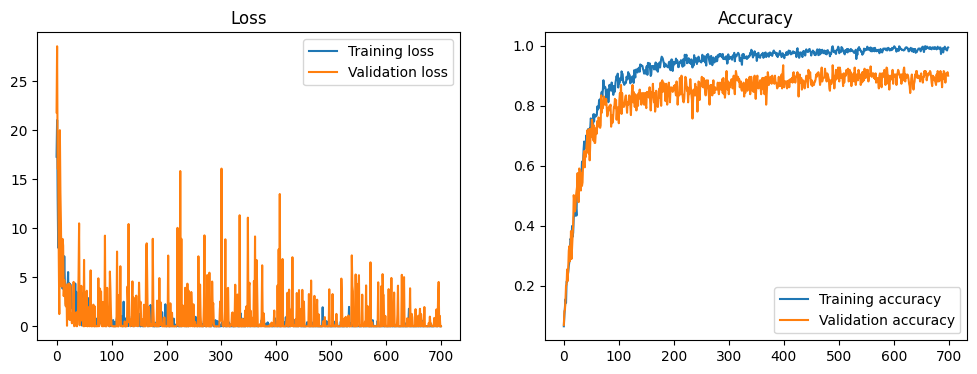

Epoch [701/1100], Loss: 6.6864245127362665e-06, Accuracy: 0.9948652118100129 Correct: 775 Total: 779 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.9227799227799228 Validation loss: 0.00025950896088033915 Correct: 239 Total: 259
Epoch [702/1100], Loss: 2.985369792440906e-05, Accuracy: 0.9922978177150192 Correct: 773 Total: 779 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.9343629343629344 Validation loss: 0.009138833731412888 Correct: 242 Total: 259
Epoch [703/1100], Loss: 1.3329164175956976e-05, Accuracy: 0.9910141206675225 Correct: 772 Total: 779 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.918918918918919 Validation loss: 3.655731461549294e-06 Correct: 238 Total: 259
Epoch [704/1100], Loss: 9.428325711269281e-07, Accuracy: 0.9884467265725289 Correct: 770 Total: 779 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9111969111969112 Validation loss: 0.0 Correct: 236 Total: 2

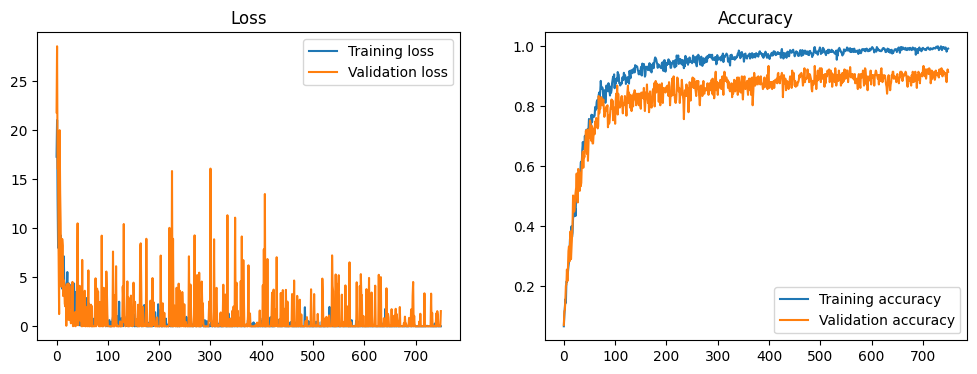

Epoch [751/1100], Loss: 0.001527339220046997, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.9343629343629344 Validation loss: 3.5762766970037774e-07 Correct: 242 Total: 259
Epoch [752/1100], Loss: 1.0837207575775665e-08, Accuracy: 0.9987163029525032 Correct: 778 Total: 779 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.9305019305019305 Validation loss: 0.0012809032341465354 Correct: 241 Total: 259
Epoch [753/1100], Loss: 2.535876546971849e-06, Accuracy: 0.9910141206675225 Correct: 772 Total: 779 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.8996138996138996 Validation loss: 4.172299213678343e-06 Correct: 233 Total: 259
Epoch [754/1100], Loss: 6.502213636849774e-06, Accuracy: 0.9922978177150192 Correct: 773 Total: 779 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.8957528957528957 Validation loss: 2.6701811293605715e-05 C

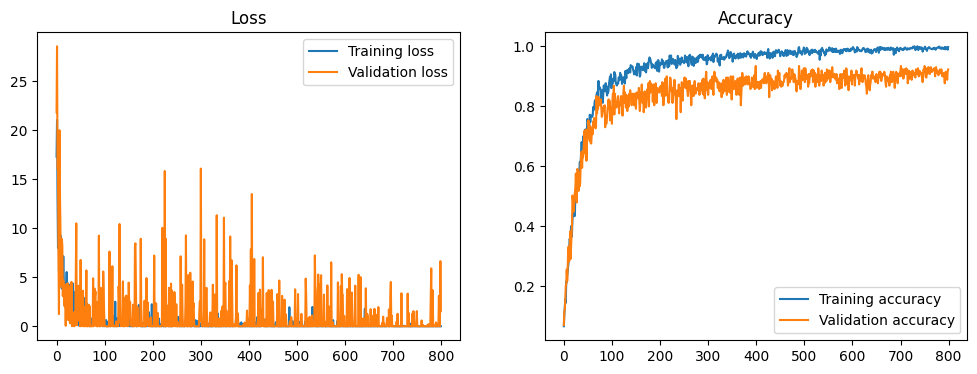

Epoch [801/1100], Loss: 0.0008698564488440752, Accuracy: 0.9884467265725289 Correct: 770 Total: 779 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9073359073359073 Validation loss: 6.0673202824546024e-05 Correct: 235 Total: 259
Epoch [802/1100], Loss: 0.22912706434726715, Accuracy: 0.9922978177150192 Correct: 773 Total: 779 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9227799227799228 Validation loss: 0.1388857215642929 Correct: 239 Total: 259
Epoch [803/1100], Loss: 0.14926093816757202, Accuracy: 0.9922978177150192 Correct: 773 Total: 779 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.9073359073359073 Validation loss: 0.0033646903466433287 Correct: 235 Total: 259
Epoch [804/1100], Loss: 1.1725494005077053e-05, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.918918918918919 Validation loss: 0.0014430711744353175 Correct: 23

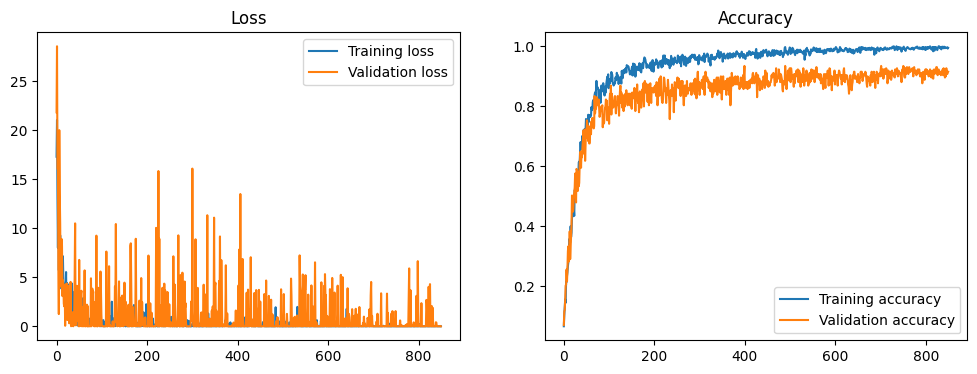

Epoch [851/1100], Loss: 0.030946167185902596, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9227799227799228 Validation loss: 0.00016760587459430099 Correct: 239 Total: 259
Epoch [852/1100], Loss: 2.44575221586274e-05, Accuracy: 0.9948652118100129 Correct: 775 Total: 779 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.8957528957528957 Validation loss: 0.0 Correct: 232 Total: 259
Epoch [853/1100], Loss: 0.00016757285629864782, Accuracy: 0.993581514762516 Correct: 774 Total: 779 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.8957528957528957 Validation loss: 0.2458772510290146 Correct: 232 Total: 259
Epoch [854/1100], Loss: 8.669736644151271e-07, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.918918918918919 Validation loss: 0.007374688517302275 Correct: 238 Total: 259
E

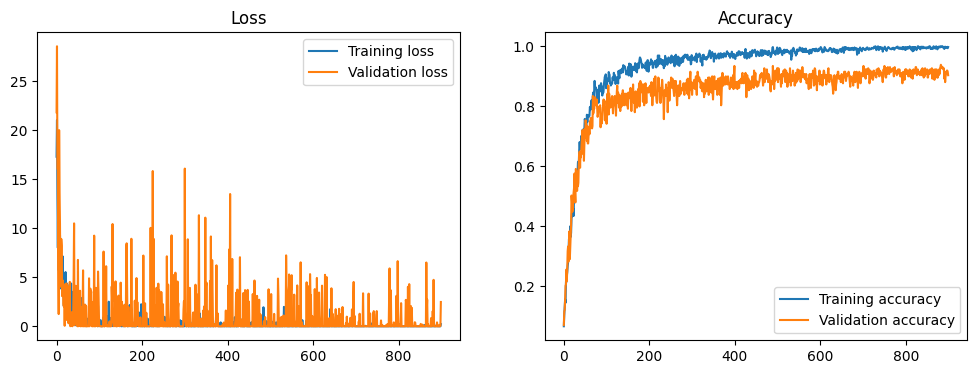

Epoch [901/1100], Loss: 0.11972825974225998, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.888030888030888 Validation loss: 0.0 Correct: 230 Total: 259
Epoch [902/1100], Loss: 2.317948565178085e-05, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.888030888030888 Validation loss: 3.973642748178463e-08 Correct: 230 Total: 259
Epoch [903/1100], Loss: 8.040852662816178e-06, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.8996138996138996 Validation loss: 1.1126015124318656e-05 Correct: 233 Total: 259
Epoch [904/1100], Loss: 4.6924565140216146e-06, Accuracy: 0.9987163029525032 Correct: 778 Total: 779 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.9227799227799228 Validation loss: 0.0 Correct: 239 Total: 259
Epoch [905/1100], Loss

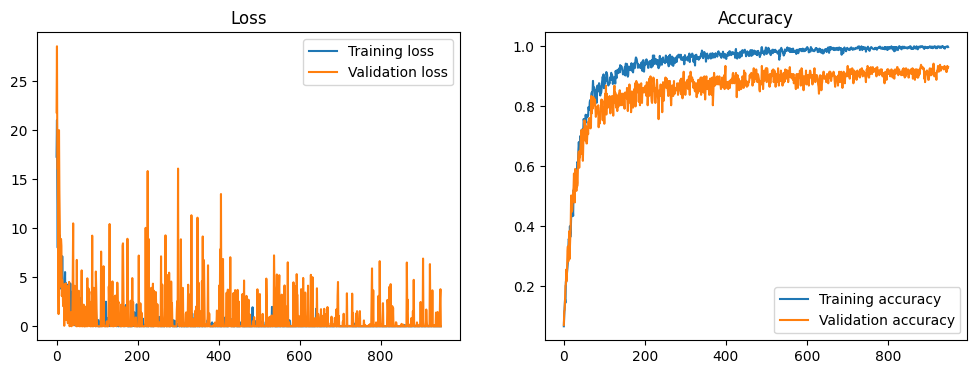

Epoch [951/1100], Loss: 2.3841548681957647e-06, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.9266409266409267 Validation loss: 5.678084562532604e-05 Correct: 240 Total: 259
Epoch [952/1100], Loss: 0.0002526982279960066, Accuracy: 1.0 Correct: 779 Total: 779 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9343629343629344 Validation loss: 3.973642748178463e-08 Correct: 242 Total: 259
Epoch [953/1100], Loss: 0.012083605863153934, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.9305019305019305 Validation loss: 6.953805041121086e-06 Correct: 241 Total: 259
Epoch [954/1100], Loss: 2.5900644686771557e-06, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.9343629343629344 Validation loss: 2.5928525924682617 Correct: 242 Total: 259
E

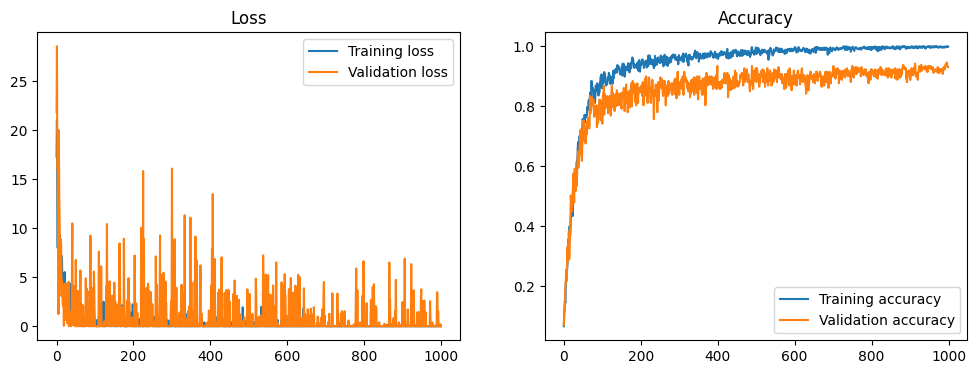

Epoch [1001/1100], Loss: 5.418602455620203e-08, Accuracy: 0.9987163029525032 Correct: 778 Total: 779 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9266409266409267 Validation loss: 0.0 Correct: 240 Total: 259
Epoch [1002/1100], Loss: 3.6846438433713047e-07, Accuracy: 1.0 Correct: 779 Total: 779 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9343629343629344 Validation loss: 1.7850933074951172 Correct: 242 Total: 259
Epoch [1003/1100], Loss: 2.8176702926430153e-07, Accuracy: 1.0 Correct: 779 Total: 779 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.918918918918919 Validation loss: 2.748804807662964 Correct: 238 Total: 259
Epoch [1004/1100], Loss: 0.0034532842691987753, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.915057915057915 Validation loss: 0.0006902618333697319 Correct: 237 Total: 259
Epoch [1005/1100], Loss: 8.669762

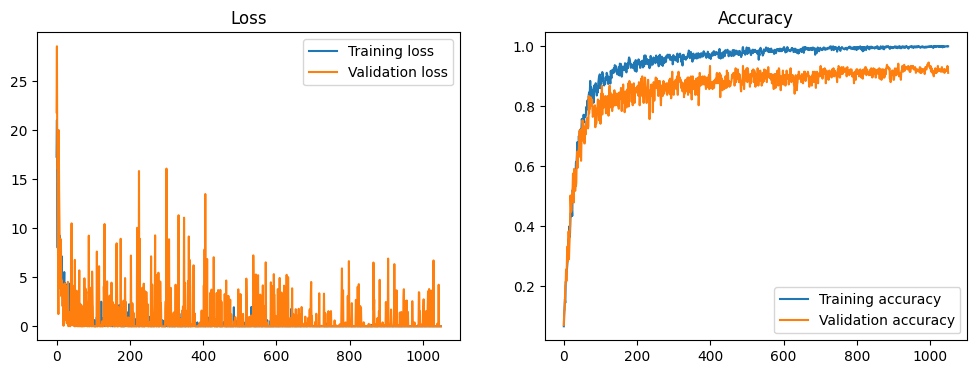

Epoch [1051/1100], Loss: 1.9506961734805373e-07, Accuracy: 0.9987163029525032 Correct: 778 Total: 779 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 0.9227799227799228 Validation loss: 4.5268049240112305 Correct: 239 Total: 259
Epoch [1052/1100], Loss: 3.337824637128506e-06, Accuracy: 1.0 Correct: 779 Total: 779 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 0.9382239382239382 Validation loss: 0.010274054482579231 Correct: 243 Total: 259
Epoch [1053/1100], Loss: 0.0001445948873879388, Accuracy: 1.0 Correct: 779 Total: 779 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.9343629343629344 Validation loss: 4.3054022789001465 Correct: 242 Total: 259
Epoch [1054/1100], Loss: 4.681598966271849e-06, Accuracy: 1.0 Correct: 779 Total: 779 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9305019305019305 Validation loss: 1.1364482816134114e-05 Correct: 241 Total: 259
Epoch [1055/1100], Loss:

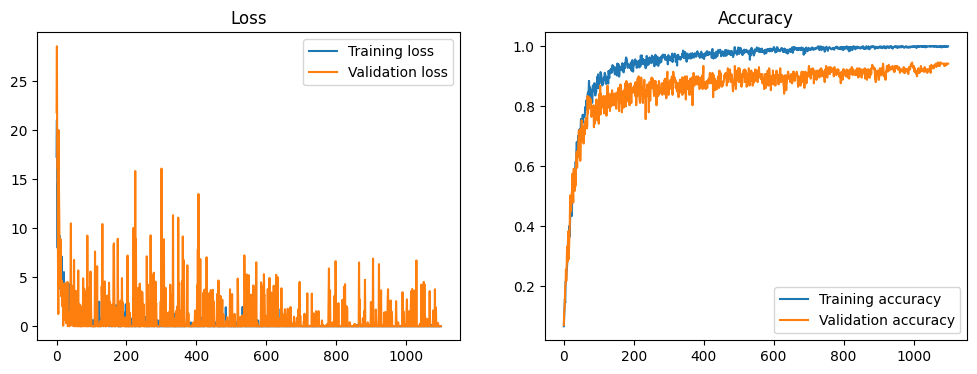

In [30]:
best_model_path = "/kaggle/working/CoAtNet-1-Best.pkl"
model_path = "/kaggle/working/CoAtNet-1.pkl"
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [31]:
save_model(model, model_path)

# Results

In [32]:
print("Best validation acc: ", max(val_accuracies))

Best validation acc:  0.9459459459459459


In [33]:
print("Last validation acc: ", val_accuracies[-1])

Last validation acc:  0.9420849420849421


In [34]:
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]
label_dict = {}
for i in range(ord('Z') - ord('A') + 1):
    label_dict[i] = alphabet[i]
print(label_dict)
len(alphabet)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


26

In [35]:
# Adapted from My_CoAtNet
predictions_path = '/kaggle/working/predictions.csv'
def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:
        character_lab = []
        character_pred = []
        
        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

## Test accuracy

In [36]:
cm = predict(test_dataloader)

Test Accuracy: 0.9382239382239382


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
predicted_labels,K,N,S,M,C,N,E,Q,A,A,A,O,Q,G,M,D,T,X,E,Y,U,B,X,N,Q,U,Z,H,D,O,I,N,Y,Q,E,F,O,P,V,C,U,Q,Q,P,S,K,F,V,Y,Q,V,H,B,X,G,W,U,B,M,N,X,K,Y,H,S,I,I,X,A,T,L,T,N,X,Z,Y,Y,G,L,I,S,S,U,V,G,T,F,M,Z,T,P,K,T,V,P,O,W,D,R,G,B,O,C,Z,W,K,G,G,B,A,X,C,W,O,D,K,J,S,U,W,O,F,Q,B,B,R,J,M,Z,V,I,C,L,T,P,J,I,P,Z,N,B,O,O,V,K,X,A,F,U,Y,O,L,T,O,T,E,K,Q,R,A,H,L,A,G,K,W,I,O,P,R,C,N,J,R,D,E,Q,J,P,V,G,C,R,J,P,H,Z,A,A,L,N,K,O,P,P,B,W,E,U,W,S,Q,S,J,N,M,J,O,X,O,P,K,Q,V,H,I,P,V,Z,C,A,X,G,V,S,X,C,J,F,J,S,J,O,T,S,B,X,V,K,P,W,M,M,N,H,P,A,B,F,H,W,Y,D,T,G,Z,V,R,R
true_labels,K,N,S,M,C,J,E,Q,A,A,A,O,Q,G,M,D,R,X,E,Y,U,B,X,N,Q,U,Z,H,D,S,I,N,Y,Q,E,F,P,P,V,C,U,Q,Q,O,S,K,F,V,Y,Q,C,H,B,X,G,W,U,B,M,N,X,K,Y,H,S,I,I,X,A,T,K,T,N,X,Z,Y,Y,G,L,I,S,S,U,V,G,T,F,M,Z,T,P,K,D,V,P,O,W,D,R,G,B,O,V,Z,W,K,G,G,B,A,X,C,W,U,D,K,J,S,U,W,O,F,Q,B,B,R,K,M,Z,V,I,C,L,T,O,J,I,P,Z,N,B,O,O,V,K,X,A,F,U,Y,O,L,T,O,T,E,K,Q,R,A,H,L,A,G,K,W,I,O,P,R,C,N,J,R,D,E,Q,J,P,V,G,C,R,J,P,H,Z,A,A,L,N,K,O,P,P,B,W,E,U,W,S,Q,S,J,N,M,J,O,X,O,P,K,Q,B,H,I,P,V,Z,C,A,X,G,C,S,X,C,J,F,J,S,J,O,T,S,B,X,V,K,P,W,M,M,N,H,E,A,J,F,H,W,Y,D,T,G,Z,V,R,R


0.9382239382239382
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.91      0.91      0.91        11
           2       0.89      0.80      0.84        10
           3       1.00      0.86      0.92         7
           4       1.00      0.86      0.92         7
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       0.91      0.83      0.87        12
          10       1.00      0.86      0.92        14
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         8
          13       0.91      1.00      0.95        10
          14       0.81      0.87      0.84        15
          15       0.80      0.92      0.86        13
          16       1.00      1.00      1.00        12
        

## Confusion matrix

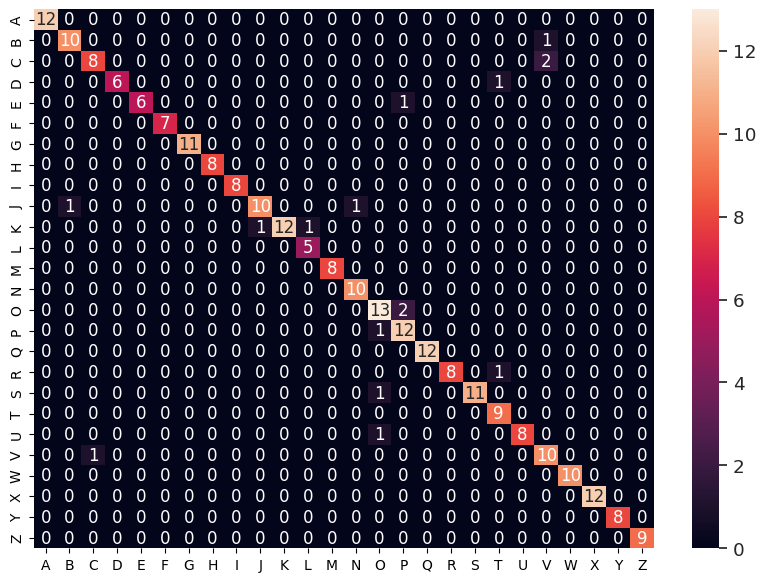

In [37]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=alphabet, 
                yticklabels=alphabet,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1")

# Acknowledgements
I have found these resources useful while writing this notebook:
1. [anastasiialobanova's My_CoAtNet Kaggle notebook](https://www.kaggle.com/code/anastasiialobanova/my-coatnet)
2. [xmu-xiaoma666's implementation of CoAtNet](https://github.com/xmu-xiaoma666/External-Attention-pytorch/blob/master/model/attention/CoAtNet.py)
3. [https://m0nads.wordpress.com/tag/self-attention/](https://github.com/xmu-xiaoma666/External-Attention-pytorch/blob/master/model/attention/CoAtNet.py)
4. [chinhsuanwu's implementation of CoAtNet](https://github.com/chinhsuanwu/coatnet-pytorch/blob/master/coatnet.py)